Export and inference example
============================
This example shows you how to use vortex runtime.
We'll use pretrained DETR COCO from facebookai.

In [1]:
%matplotlib inline
from PIL import Image
import requests
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False)

In [3]:
import numpy as np
import urllib

Model Preparation
=================

The following model is taken from
https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb
We will use this model to export to onnx before using vortex runtime

In [4]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [5]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [6]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [7]:
size = (480,640)
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(size),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

In [9]:
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [10]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [11]:
def test_image(as_numpy=True):
    url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    filename = url.split('/')[-1]
    urllib.request.urlretrieve(url, url.split('/')[-1])
    img = Image.open(filename)

    if as_numpy:
        img = np.array(img)
        img = np.expand_dims(img,0)
    return img

In [12]:
def demo():
    detr = DETRdemo(num_classes=91)
    state_dict = torch.hub.load_state_dict_from_url(
        url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
        map_location='cpu', check_hash=True)
    detr.load_state_dict(state_dict)
    detr.eval()

    im = test_image(as_numpy=False)
    scores, boxes = detect(im, detr, transform)

    def plot_results(pil_img, prob, boxes):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.show()
    
    print(boxes)
    print(scores.max(-1))
        
    plot_results(im, scores, boxes)

Preprocess and Postprocess
==========================

Here, we'll prepare some preprocess and postprocess for this specific model.
This is not really required, but note that vortex runtime doesn't provide
preprocess and postprocess, and in general it is nice to include preprocess
and postprocess to model.
Furthermore, the preprocess and postprocess don't have to implemented as separate
nn.Module, but for the sake of clarity and modularity, we'll implement it as
separate modules and then compose them in another nn.Module

Note that by default vortex use BGR channel order and expect NHWC layout,
this behaviour can be adjusted by subclassing but we'll stick to default for now.

In [13]:
class DETRPreprocess(nn.Module):
    __constants__ = ['mean','std','scale']
    def __init__(self):
        super().__init__()
        #  value for RGB
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(-1,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).reshape(-1,1,1)
        # scale to 0...1
        scale = torch.tensor([255.],dtype=torch.float32)
        self.register_buffer('mean', mean)
        self.register_buffer('std', std)
        self.register_buffer('scale', scale)
    
    def forward(self, x):
        # assume NHWC layout,
        # reverse order from BGR to RGB
        # since the weight is trained in RGB format
        x = torch.flip(x,[-1])
        # transpose from NHWC to NCHW
        x = x.permute(0,3,1,2)
        # finally normalize the value
        # and we're done
        x = x.div(self.scale)
        x = x.sub_(self.mean).div_(self.std)
        return x

The postprocess for this specific model is softmax and thresholding.

In [14]:
class DETRPostProcess(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, outputs, score_threshold):
        # from the model above, we know that the output is dictionary of tensor
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        # peform softmax and extract confidence score and labels
        prob = torch.nn.functional.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # selection based on threshold
        # assume single batch
        keep = scores > score_threshold
        keep = keep.nonzero()[...,-1]
        out_bbox = torch.index_select(out_bbox,index=keep,dim=1)
        # unsqueeze to match dimension of out_bbox
        scores = torch.index_select(scores,index=keep,dim=1).unsqueeze(-1)
        labels = torch.index_select(labels,index=keep,dim=1).float().unsqueeze(-1)

        # convert to xyxy and then join them together
        # also note the order of the output tensor, no specific order is necessary
        # but we'll tell vortex about our format later.
        # For clarity, this format is [x1,y1,x2,y2,score,label] for each detected instance.
        # Also note that we have 3-dimensional output NxDx6,
        # where N is number of batch (1 in this case), D is the number of detected object,
        # and 6 is the detection value (bounding box, scores and label).
        bboxes = box_cxcywh_to_xyxy(out_bbox.squeeze(0)).unsqueeze(0)
        return torch.cat((bboxes,scores,labels),-1)

Having set the preprocess and postprocess now we compose them together with the model.

In [15]:
class DETR(DETRdemo):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.preprocess  = DETRPreprocess()
        self.postprocess = DETRPostProcess()

    def forward(self, x, score_threshold):
        x = self.preprocess(x)
        x = super().forward(x)
        x = self.postprocess(x,score_threshold)
        return x

In [16]:
filename = "detr.onnx"
import cv2

Export
======

Here we will actually export the model.
We'll use `torch.onnx` to export the model and add additional properties to
model using helper function from vortex.
Basically we need to tell vortex about the format of the final output tensor and class names.

In [17]:
def export():
    detr = DETR(num_classes=91)
    state_dict = torch.hub.load_state_dict_from_url(
        url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
        map_location='cpu', check_hash=True)
    detr.load_state_dict(state_dict,strict=False)
    detr.eval()

    # read the test image, then resize it
    img = test_image()
    img = cv2.resize(img[0],size[::-1])
    img = torch.from_numpy(img).unsqueeze(0)

    export_args = dict(
        input_names=["input", "score_threshold"],
        output_names=["output"],
        opset_version=11,
    )

    # use torch.onnx to export
    example_input = (img,torch.tensor([0.7]))
    torch.onnx.export(detr,example_input,filename,**export_args)

    # having exported the output, now we'll add additional property to the model
    import vortex.runtime.onnx.graph_ops.embed_model_property as g
    import onnx

    # First, lets prepare output_format, this will be used to construct
    # the final output by applying np.take for each batch.
    # The format is nested dictionary with outer dict represents the
    # name of output and the inner dictionary represents arguments for take,
    # that is indices and axis (see numpy take docs for more detail).
    #
    # In this case we have 3-dimensional array with NxDx6 shape, so
    # vortex will apply item selection at Dx6 array. So we'll apply
    # slicing (take) at axis 1.
    # 
    # As mentioned in postprocess section we'll returning tensor
    # with [x1,y1,x2,y2,score,label] for each detection,
    # so for bounding_box, we'll select indices 0 to 3,
    # index 4 for score, and index 5 for label.

    # will use InferenceHelper which assume the following names,
    # if different names are desired, may customize visualizer
    output_format = dict(
        bounding_box=dict(
            indices=[0,1,2,3],
            axis=1,
        ),
        class_confidence=dict(
            indices=[4],
            axis=1,
        ),
        class_label=dict(
            indices=[5],
            axis=1,
        )
    )
    # class_names is just list of string
    class_names = CLASSES
    # pack output_format and class_names as dictionary
    model_props = dict(
        output_format=output_format,
        class_names=class_names,
    )

    # finally apply transformation and save
    f = g.EmbedModelProperty(model_props)
    model = onnx.load(filename)
    model = f(model)
    onnx.save(model,filename)

Inference
=========

In [18]:
# Now we will run the exported model using vortex runtime
# There is helper class InferenceHelper that is simple wrapper
# for visualization and actual runtime model.
def inference():
    from vortex.runtime.helper import InferenceHelper
    import cv2

    # prepare test image, as NHWC with BGR channel order
    img = test_image()
    img = np.flip(img,-1)
    img = cv2.resize(img[0],size[::-1])[None,...]

    # construct runtime model with visualization
    kwargs = dict(
        model_path=filename,
        runtime='cpu',
    )
    rt = InferenceHelper.create_runtime_model(**kwargs)

    # prepare arguments for inference,
    # note that the name 'score_threshold'
    # will be forwarded to the actual runtime model
    # hence the name should match the actual model itself.
    kwargs = dict(
        score_threshold=0.7,
        visualize=True,
    )
    result = rt(img,**kwargs)
    print(result['prediction'])

    if 'visualization' in result:
        # visualize first batch
        visual = result['visualization'][0]
        visual = np.flip(visual,2)
        plt.imshow(visual)
        plt.show()

tensor([[1.6654e+01, 5.2351e+01, 3.0964e+02, 4.6890e+02],
        [3.9025e+01, 7.0671e+01, 1.7513e+02, 1.1438e+02],
        [3.4225e+02, 2.2125e+01, 6.3985e+02, 3.7032e+02],
        [4.1021e-01, 1.1360e+00, 6.4029e+02, 4.7371e+02],
        [1.0654e-01, 6.7570e-01, 6.4009e+02, 4.7473e+02],
        [3.3631e+02, 7.8008e+01, 3.6540e+02, 1.8914e+02]])
torch.return_types.max(
values=tensor([0.9988, 0.9972, 0.9983, 0.8771, 0.9304, 0.7776]),
indices=tensor([17, 75, 17, 63, 65, 75]))


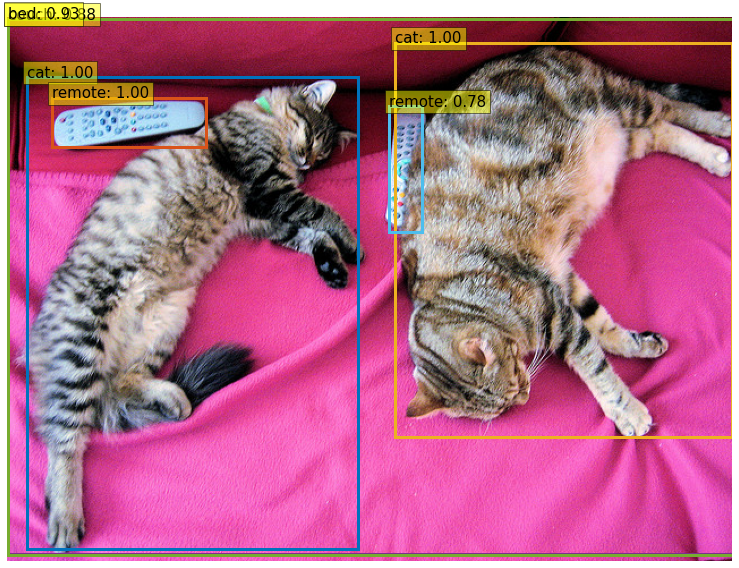

/home/nodeflux/.venv/vortex2/lib/python3.6/site-packages/ipykernel_launcher.py:59: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/nodeflux/.venv/vortex2/lib/python3.6/site-packages/ipykernel_launcher.py:60: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


[OrderedDict([('bounding_box', array([[1.66539001e+01, 5.23505249e+01, 3.09644104e+02, 4.68896484e+02],
       [3.90249825e+01, 7.06708755e+01, 1.75133118e+02, 1.14377396e+02],
       [3.42251831e+02, 2.21247196e+01, 6.39854980e+02, 3.70317566e+02],
       [4.10270691e-01, 1.13596916e+00, 6.40291443e+02, 4.73707367e+02],
       [1.06563568e-01, 6.75702095e-01, 6.40088501e+02, 4.74727539e+02],
       [3.36309021e+02, 7.80080643e+01, 3.65395325e+02, 1.89143066e+02]],
      dtype=float32)), ('class_confidence', array([[0.9988431 ],
       [0.9972224 ],
       [0.99827087],
       [0.87714374],
       [0.93038386],
       [0.7776202 ]], dtype=float32)), ('class_label', array([[17.],
       [75.],
       [17.],
       [63.],
       [65.],
       [75.]], dtype=float32))])]


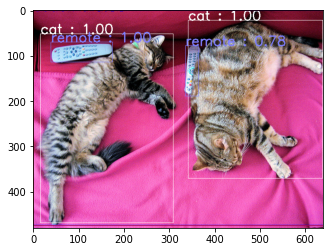

In [19]:
if __name__=='__main__':
    demo()
    export()
    inference()